# Step 1: Install Libraries

In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s e

# Step 2: Import Libraries

In [2]:
import gc
import os
import shutil
import random

import kagglehub
import numpy as np

from tqdm import tqdm
from typing import Tuple, Optional, Dict

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Step 3: Download Dataset

In [3]:
source_path = kagglehub.dataset_download("gpiosenka/sports-classification")
destination_path = "/content/Dataset"
if os.path.exists(destination_path):
    shutil.rmtree(destination_path)
shutil.copytree(source_path, destination_path)

100%|██████████| 424M/424M [00:10<00:00, 40.6MB/s]

Extracting files...


'/content/Dataset'

# Step 4: Data Augmentation

In [5]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, n_copies=3):
        self.base_dataset = base_dataset
        self.n_copies = n_copies
        self.classes = base_dataset.classes
        self.class_to_idx = base_dataset.class_to_idx

        # More diverse augmentations
        self.augmentations = [
            None,  # Original
            transforms.Compose([
                transforms.RandomHorizontalFlip(p=1.0),
                transforms.RandomRotation(degrees=10),
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
            ]),
        ]

    def __len__(self):
        return len(self.base_dataset) * self.n_copies

    def __getitem__(self, idx):
        original_idx = idx // self.n_copies
        aug_idx = idx % self.n_copies

        image, label = self.base_dataset[original_idx]

        if aug_idx > 0 and self.augmentations[aug_idx] is not None:
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(image)
            image = self.augmentations[aug_idx](image)
            image = self.base_dataset.transform(image)

        return image, label

# Step 5: Loading Dataset

In [6]:
class ImageDataLoader:
    def __init__(
        self,
        root_path: str = '/content/Dataset',
        batch_size: int = 32,
        image_size: Tuple[int, int] = (512, 512),
        mean: float = 0.5,
        std: float = 0.5,
        augmentation: bool = True,
        n_copies: int = 3,
        num_workers: int = 2,
        use_grayscale: bool = True
    ):
        self.root_path = root_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.mean = mean
        self.std = std
        self.augmentation = augmentation
        self.n_copies = n_copies
        self.num_workers = num_workers
        self.use_grayscale = use_grayscale

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None
        self.train_loader = None
        self.validation_loader = None
        self.test_loader = None
        self.classes = None
        self.class_to_idx = None

        self._setup_datasets()
        self._setup_loaders()

    def _get_transforms(self, augmentation: bool = False) -> transforms.Compose:
        base_transforms = [
            transforms.Resize(self.image_size),
        ]

        if self.use_grayscale:
            base_transforms.append(transforms.Grayscale(num_output_channels=1))

        base_transforms.extend([
            transforms.ToTensor(),
            transforms.Normalize([self.mean], [self.std]) if self.use_grayscale
            else transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        return transforms.Compose(base_transforms)

    def _setup_datasets(self) -> None:
        train_transform = self._get_transforms(augmentation=self.augmentation)
        self.train_dataset = datasets.ImageFolder(
            root=f'{self.root_path}/train',
            transform=train_transform
        )

        val_transform = self._get_transforms(augmentation=False)
        self.val_dataset = datasets.ImageFolder(
            root=f'{self.root_path}/valid',
            transform=val_transform
        )

        self.test_dataset = datasets.ImageFolder(
            root=f'{self.root_path}/test',
            transform=val_transform
        )

        if self.augmentation:
            self.train_dataset = AugmentedDataset(self.train_dataset, n_copies=self.n_copies)

        self.classes = self.train_dataset.classes
        self.class_to_idx = self.train_dataset.class_to_idx

    def _setup_loaders(self) -> None:
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def get_dataset_sizes(self) -> Dict[str, int]:
        return {
            'train': len(self.train_dataset),
            'val': len(self.val_dataset),
            'test': len(self.test_dataset)
        }

    def get_class_info(self) -> Dict:
        return {
            'classes': self.classes,
            'class_to_idx': self.class_to_idx,
            'num_classes': len(self.classes)
        }

    def show_sample(self, dataset_type: str = 'train') -> Optional[Tuple[torch.Tensor, torch.Tensor]]:
        loader = {
            'train': self.train_loader,
            'validation': self.val_loader,
            'test': self.test_loader
        }.get(dataset_type.lower(), None)

        if loader is None:
            print(f"Invalid dataset type: {dataset_type}. Choose from 'train', 'validation', or 'test'")
            return None

        images, labels = next(iter(loader))

        indices = torch.randperm(len(images))[:10]
        images = images[indices]
        labels = labels[indices]

        # Denormalize for display
        mean = torch.tensor(self.mean).view(1, 1, 1)
        std = torch.tensor(self.std).view(1, 1, 1)
        images = images * std + mean
        images = images.clamp(0, 1)

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle(f"Random samples from {dataset_type} set", fontsize=16)

        for i, ax in enumerate(axes.flat):
            if i < 10:
                ax.imshow(images[i].numpy().transpose((1, 2, 0)), cmap='gray')
                ax.set_title(self.classes[labels[i]], fontsize=10)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

Dataset sizes: {'train': 40476, 'val': 500, 'test': 500}
Class information: {'classes': ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 

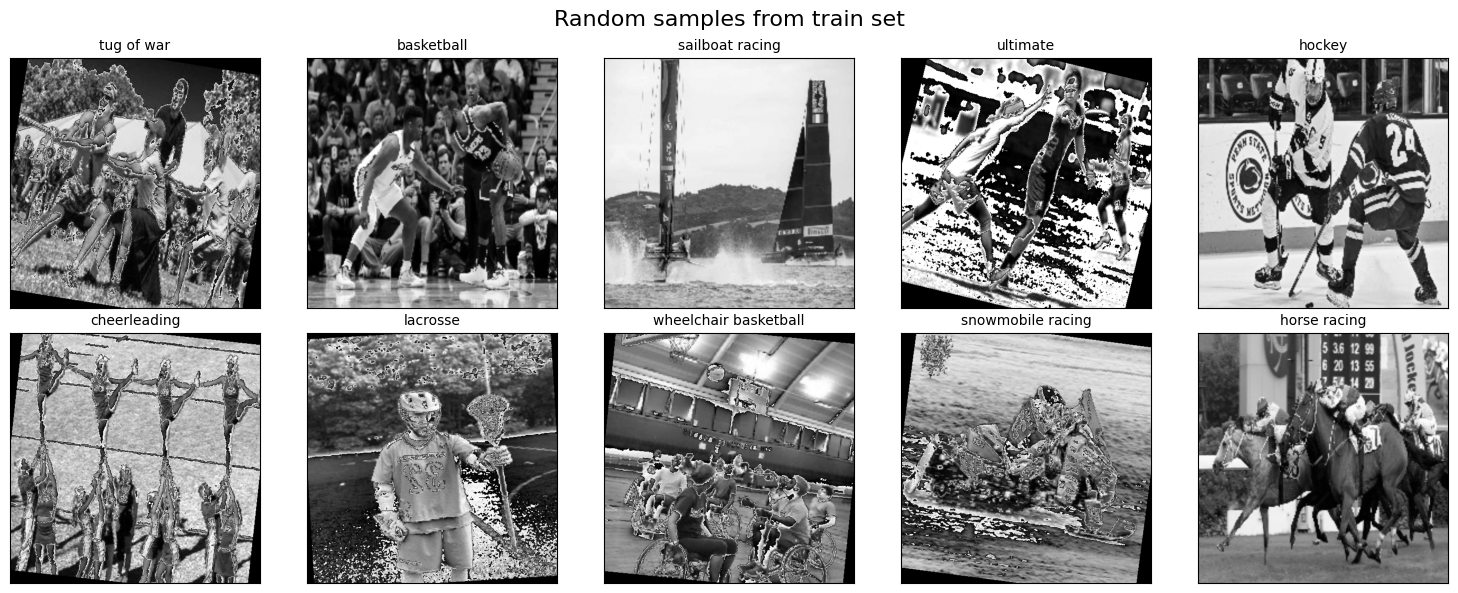

In [7]:
data_loader = ImageDataLoader(
    root_path='/content/Dataset',
    batch_size=32,
    image_size=(512, 512),
    augmentation=True,
    n_copies=3,
    num_workers=2,
    use_grayscale=True
)

train_loader = data_loader.train_loader
val_loader = data_loader.val_loader
test_loader = data_loader.test_loader

print("Dataset sizes:", data_loader.get_dataset_sizes())
print("Class information:", data_loader.get_class_info())

data_loader.show_sample()

# Step 6: Defining Model

In [9]:
class SportVGG(nn.Module):
    def __init__(self, num_classes: int = 100, use_grayscale: bool = True, dropout_rate: float = 0.5):
        super(SportVGG, self).__init__()

        vgg = vgg19(weights=VGG19_Weights.DEFAULT)

        if use_grayscale:
            original_conv = vgg.features[0]
            new_conv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
            with torch.no_grad():
                new_conv.weight = nn.Parameter(original_conv.weight.mean(dim=1, keepdim=True))
                new_conv.bias = original_conv.bias
            vgg.features[0] = new_conv

        for i, param in enumerate(vgg.features.parameters()):
            if i < 15:
                param.requires_grad = False
            else:
                param.requires_grad = True

        self.features = vgg.features
        self.feature_dropout = nn.Dropout2d(0.2)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(512 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.feature_dropout(x)
        x = self.classifier(x)
        return x

# Step 7: Setting Device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 8: Training Model

In [11]:
model = SportVGG(num_classes=len(data_loader.classes), use_grayscale=True).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW([
    {'params': [p for p in model.features.parameters() if p.requires_grad], 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 185MB/s]


In [12]:
def train_model(model, data_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            loader = data_loader.train_loader if phase == 'train' else data_loader.val_loader

            for inputs, labels in tqdm(loader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().numpy())
                scheduler.step()
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().numpy())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()

        print(f'Current LR: {scheduler.get_last_lr()[0]:.2e}')
        print()

    print(f'Best Val Acc: {best_acc:.4f}')

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, history

# Step 9: GPU Memory Usage

In [13]:
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.1f} GB")

GPU Memory: 14.7 GB
GPU Memory Allocated: 0.2 GB


# Step 10: Training Loop

In [14]:
model, history = train_model(
    model=model,
    data_loader=data_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=5,
    device=device
)

Epoch 1/5
----------


train: 100%|██████████| 1265/1265 [31:24<00:00,  1.49s/it]


train Loss: 2.6824 Acc: 0.4514


val: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


val Loss: 1.4470 Acc: 0.8340
Current LR: 9.96e-06

Epoch 2/5
----------


train: 100%|██████████| 1265/1265 [31:28<00:00,  1.49s/it]


train Loss: 1.7992 Acc: 0.7140


val: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


val Loss: 1.2896 Acc: 0.9100
Current LR: 9.86e-06

Epoch 3/5
----------


train: 100%|██████████| 1265/1265 [31:24<00:00,  1.49s/it]


train Loss: 1.5547 Acc: 0.8014


val: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


val Loss: 1.2595 Acc: 0.9080
Current LR: 9.68e-06

Epoch 4/5
----------


train: 100%|██████████| 1265/1265 [30:49<00:00,  1.46s/it]


train Loss: 1.4164 Acc: 0.8501


val: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


val Loss: 1.2206 Acc: 0.9240
Current LR: 9.44e-06

Epoch 5/5
----------


train: 100%|██████████| 1265/1265 [30:43<00:00,  1.46s/it]


train Loss: 1.3234 Acc: 0.8828


val: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

val Loss: 1.2034 Acc: 0.9320
Current LR: 9.14e-06

Best Val Acc: 0.9320


# Step 11: Evaluating test set

In [17]:
def evaluate_test_set(model, test_loader, device, classes):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)

    criterion = nn.CrossEntropyLoss()

    print("Evaluating on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item() if labels.size(0) > 1 else c.item()
                class_total[label] += 1

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f"\n{'='*60}")
    print(f"TEST SET RESULTS")
    print(f"{'='*60}")
    print(f"Test Accuracy: {test_accuracy:.2f}% ({correct}/{total})")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"{'='*60}")

    class_accuracies = []
    for i in range(len(classes)):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            class_accuracies.append((classes[i], acc, class_correct[i], class_total[i]))
        else:
            class_accuracies.append((classes[i], 0.0, 0, 0))

    class_accuracies.sort(key=lambda x: x[1], reverse=True)

    print(f"\nALL CLASSES SORTED BY ACCURACY (BEST TO WORST):")
    print(f"{'Rank':<5} {'Class':<25} {'Accuracy':<10} {'Correct':<8} {'Total':<8}")
    print("-" * 60)
    for rank, (class_name, acc, correct_count, total_count) in enumerate(class_accuracies, 1):
        print(f"{rank:<5} {class_name:<25} {acc:>7.1f}%   {correct_count:>6}/{total_count:>5}")

    return {
        'accuracy': test_accuracy,
        'loss': avg_test_loss,
        'predictions': all_predictions,
        'labels': all_labels,
        'class_accuracies': class_accuracies
    }

In [18]:
print("\n" + "="*60)
print("EVALUATING MODEL ON TEST SET")
print("="*60)

test_results = evaluate_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    classes=data_loader.classes
)


EVALUATING MODEL ON TEST SET
Evaluating on test set...


Testing: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


TEST SET RESULTS
Test Accuracy: 94.40% (472/500)
Test Loss: 0.2238

ALL CLASSES SORTED BY ACCURACY (BEST TO WORST):
Rank  Class                     Accuracy   Correct  Total   
------------------------------------------------------------
1     air hockey                  100.0%        5/    5
2     ampute football             100.0%        5/    5
3     archery                     100.0%        5/    5
4     arm wrestling               100.0%        5/    5
5     balance beam                100.0%        5/    5
6     barell racing               100.0%        5/    5
7     basketball                  100.0%        5/    5
8     bike polo                   100.0%        5/    5
9     billiards                   100.0%        5/    5
10    bobsled                     100.0%        5/    5
11    bowling                     100.0%        5/    5
12    boxing                      100.0%        5/    5
13    bull riding                 100.0%        5/    5
14    bungee jumping             

# Step 12: Plot training history

In [19]:
def plot_training_history(history, test_acc=None, test_loss=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Training', color='green', marker='o', alpha=0.7)
    ax1.plot(history['val_acc'], label='Validation', color='blue', marker='s', alpha=0.7)

    if test_acc is not None:
        ax1.axhline(y=test_acc/100, color='purple', linestyle='--',
                    label=f'Test (Final: {test_acc:.2f}%)', linewidth=2)
        ax1.plot(len(history['val_acc'])-1, history['val_acc'][-1],
                'o', color='purple', markersize=8, markeredgewidth=2,
                markeredgecolor='black', label='_nolegend_')

    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.05)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['train_loss'], label='Training', color='green', marker='o', alpha=0.7)
    ax2.plot(history['val_loss'], label='Validation', color='blue', marker='s', alpha=0.7)

    if test_loss is not None:
        ax2.axhline(y=test_loss, color='purple', linestyle='--',
                   label=f'Test (Final: {test_loss:.4f})', linewidth=2)
        ax2.plot(len(history['val_loss'])-1, history['val_loss'][-1],
                'o', color='purple', markersize=8, markeredgewidth=2,
                markeredgecolor='black', label='_nolegend_')

    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

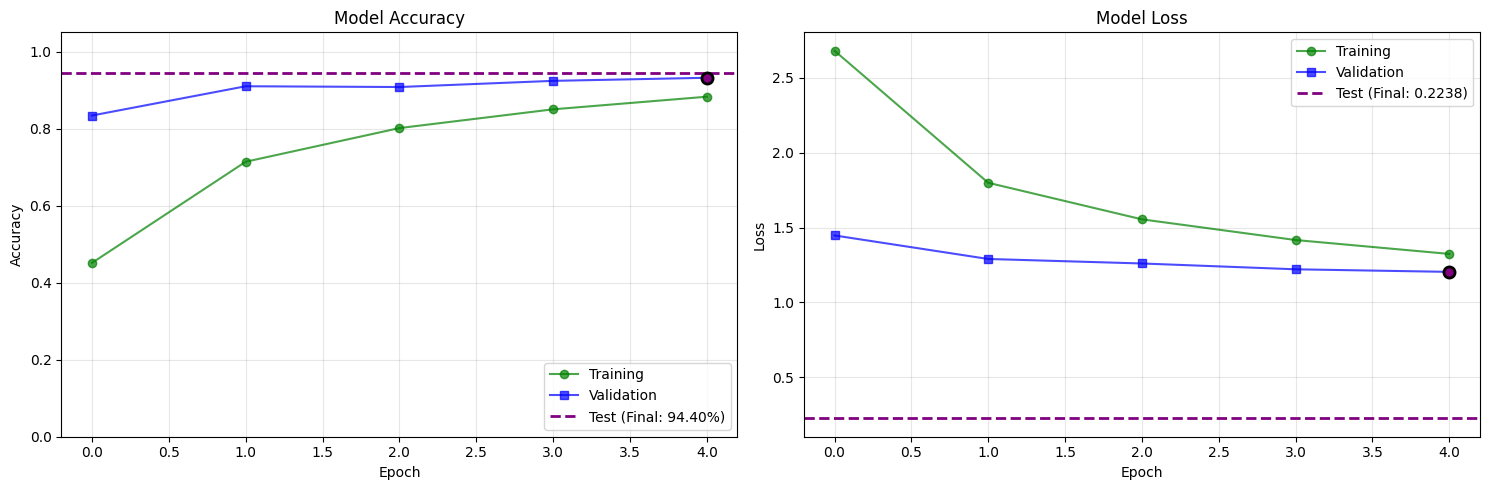

In [20]:
plot_training_history(
    history=history,
    test_acc=test_results['accuracy'],
    test_loss=test_results['loss']
)

# Step 13 : Grad Cam

In [21]:
def generate_gradcam_heatmap(model, input_tensor, target_class=None, use_cuda=True):

    device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    input_tensor = input_tensor.to(device)

    model.eval()
    target_layers = [model.features[-1]]

    cam = GradCAM(model=model, target_layers=target_layers)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    if target_class is None:
        target_class = predicted_class

    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    heatmap = grayscale_cam[0, :]

    return heatmap, predicted_class, output

def visualize_gradcam(image_path, model, target_class=None, use_grayscale=True, figsize=(12, 4), save_path=None):

    if use_grayscale:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")

        image_resized = cv2.resize(image, (224, 224))
        rgb_image = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
        rgb_image = rgb_image.astype(np.float32) / 255.0

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

        input_tensor = transform(image_resized).unsqueeze(0)

    else:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image, (224, 224))
        rgb_image = image_resized.astype(np.float32) / 255.0

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        input_tensor = transform(image_resized).unsqueeze(0)

    heatmap, predicted_class, prediction = generate_gradcam_heatmap(
        model, input_tensor, target_class
    )

    cam_image = show_cam_on_image(rgb_image, heatmap, use_rgb=True)

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    axes[0].imshow(rgb_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(cam_image)
    axes[2].set_title(f'Grad-CAM Overlay\nPredicted: Class {predicted_class}')
    axes[2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return heatmap, prediction, predicted_class

In [22]:
def show_gradcam_simple(image_path, model, use_grayscale=True, target_class=None):
    heatmap, prediction, predicted_class = visualize_gradcam(
        image_path=image_path,
        model=model,
        target_class=target_class,
        use_grayscale=use_grayscale
    )

    return heatmap, predicted_class

In [23]:
def show_gradcam_for_random_samples(dataset_root, model, num_samples=10, image_name='1.jpg'):
    class_folders = [f for f in os.listdir(dataset_root)
                    if os.path.isdir(os.path.join(dataset_root, f))]
    selected_folders = random.sample(class_folders, min(num_samples, len(class_folders)))
    for folder in selected_folders:
        image_path = os.path.join(dataset_root, folder, image_name)
        if os.path.exists(image_path):
            print(f"\nShowing Grad-CAM for: {image_path}")
            show_gradcam_simple(image_path, model)
        else:
            print(f"Image {image_path} not found, skipping...")


Showing Grad-CAM for: Dataset/valid/bobsled/1.jpg


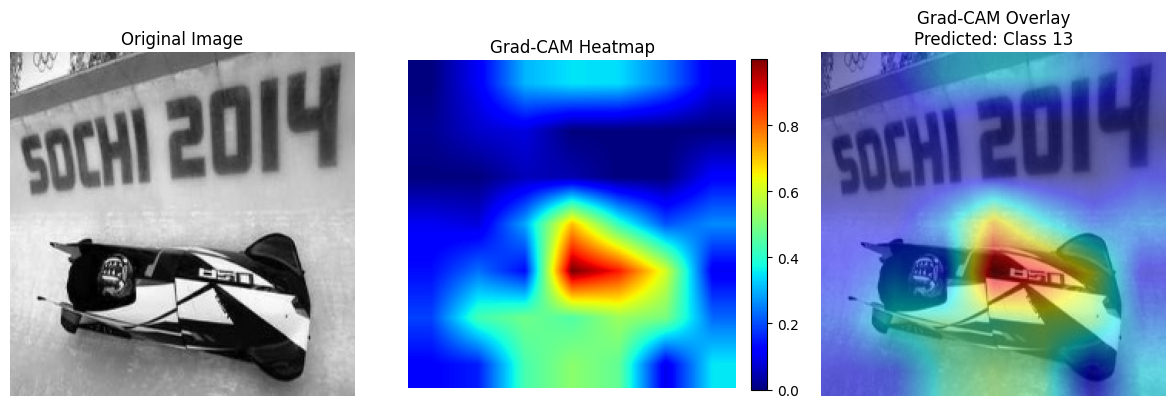


Showing Grad-CAM for: Dataset/valid/nascar racing/1.jpg


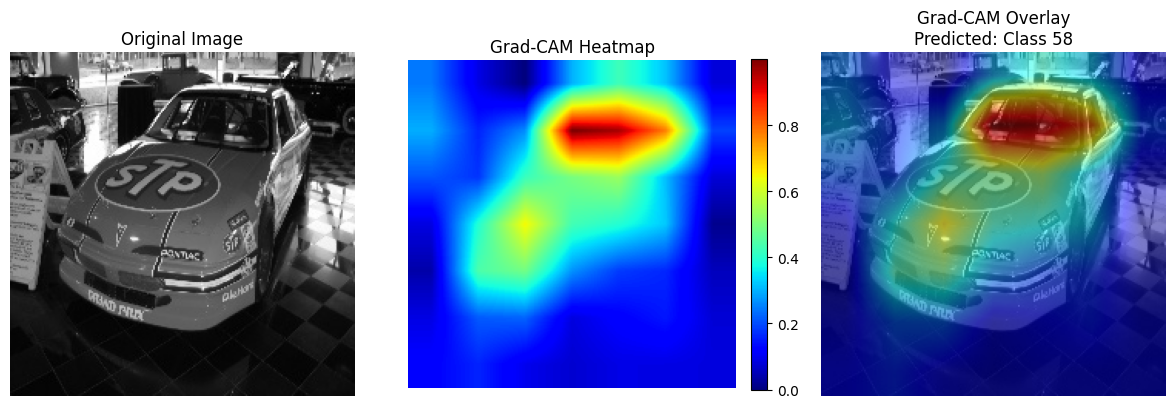


Showing Grad-CAM for: Dataset/valid/disc golf/1.jpg


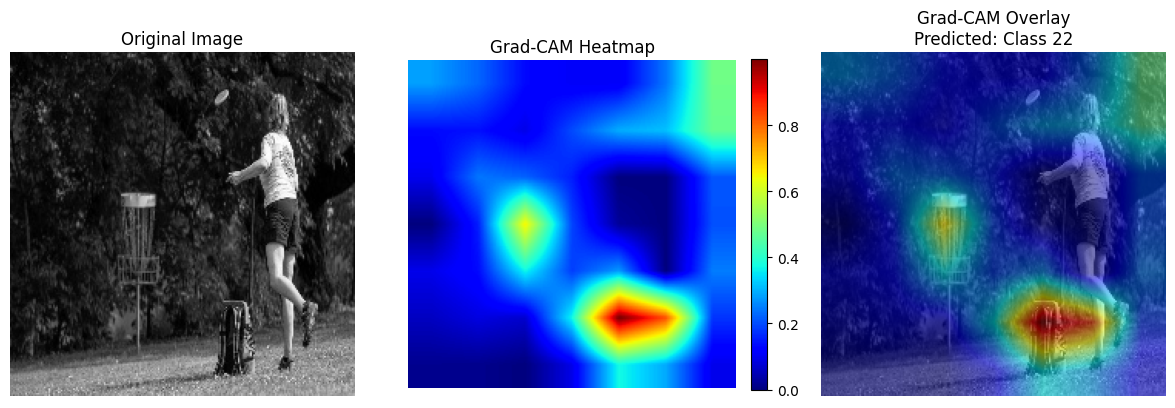


Showing Grad-CAM for: Dataset/valid/figure skating women/1.jpg


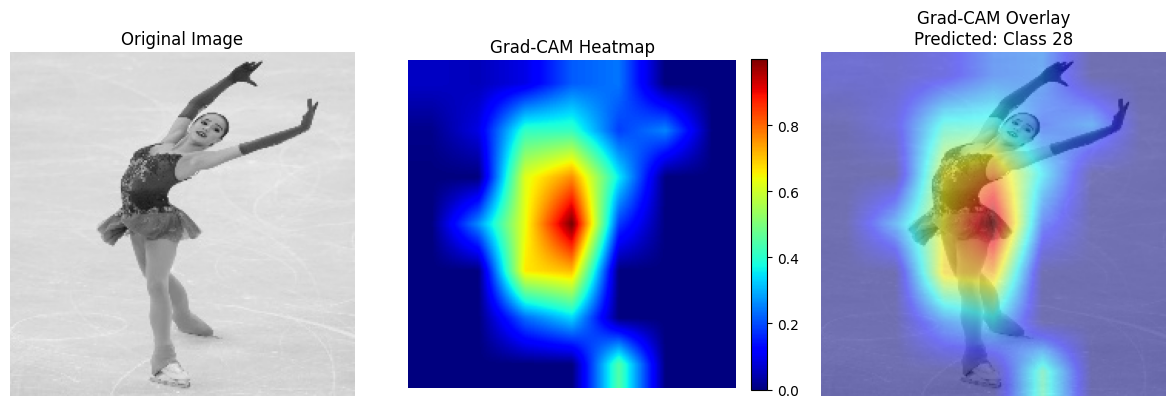


Showing Grad-CAM for: Dataset/valid/water cycling/1.jpg


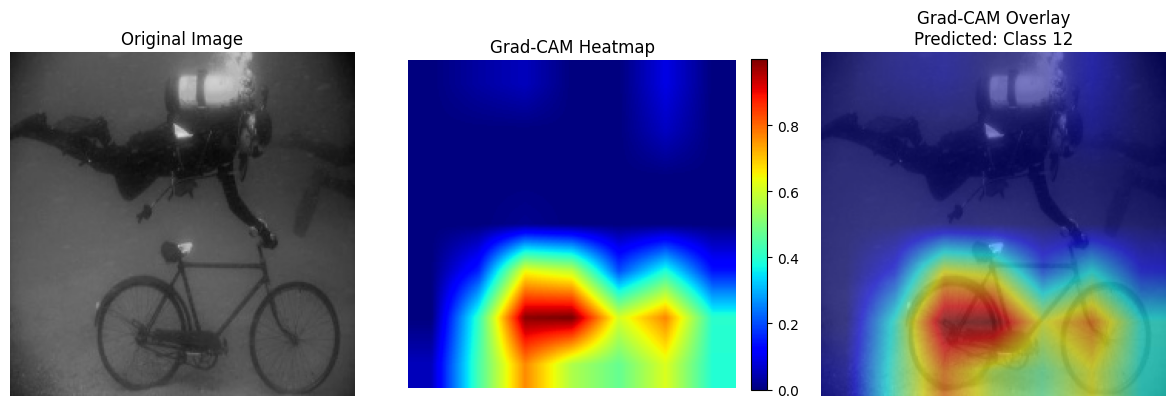


Showing Grad-CAM for: Dataset/valid/water polo/1.jpg


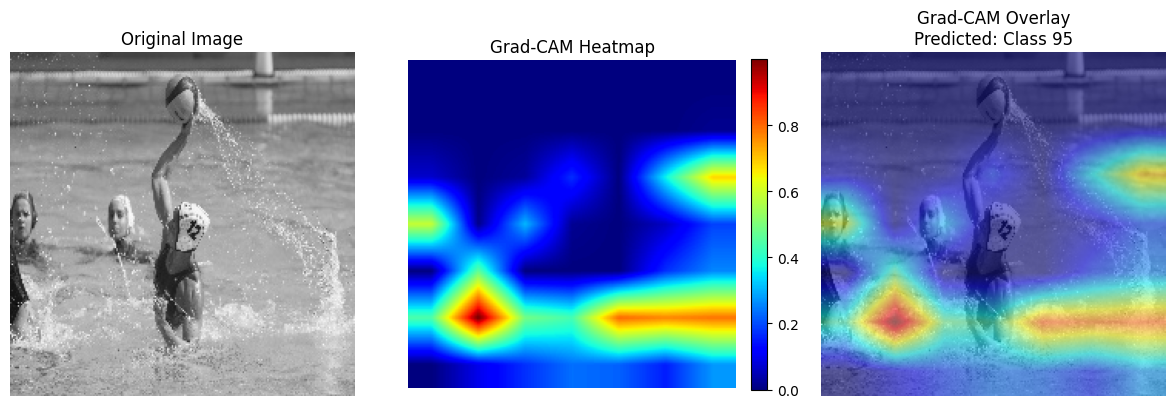


Showing Grad-CAM for: Dataset/valid/figure skating pairs/1.jpg


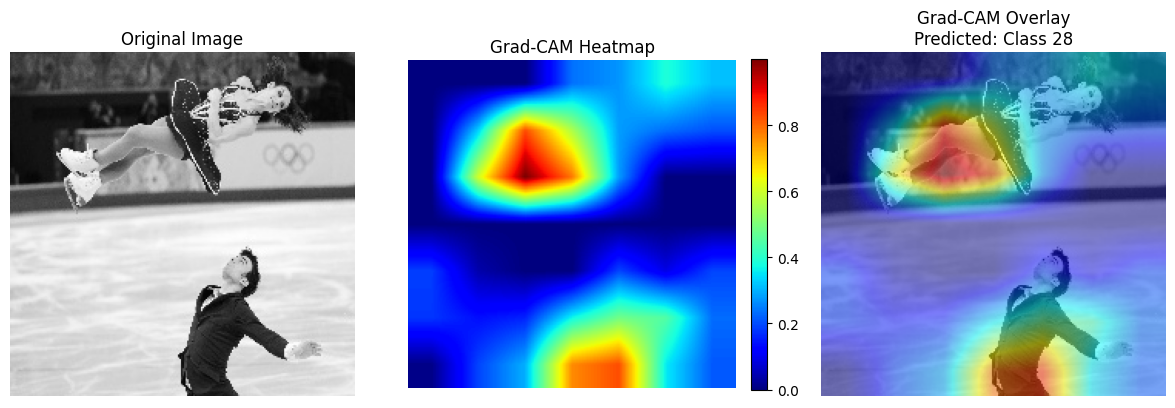


Showing Grad-CAM for: Dataset/valid/arm wrestling/1.jpg


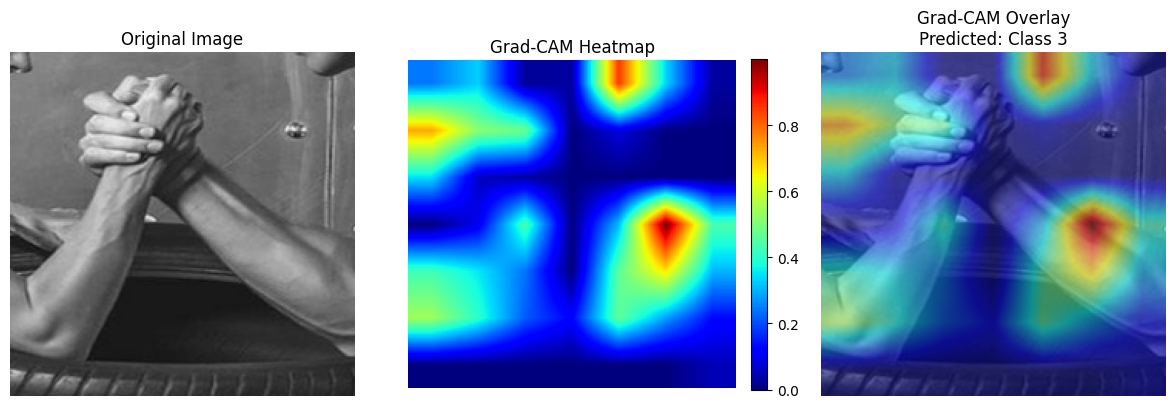


Showing Grad-CAM for: Dataset/valid/rowing/1.jpg


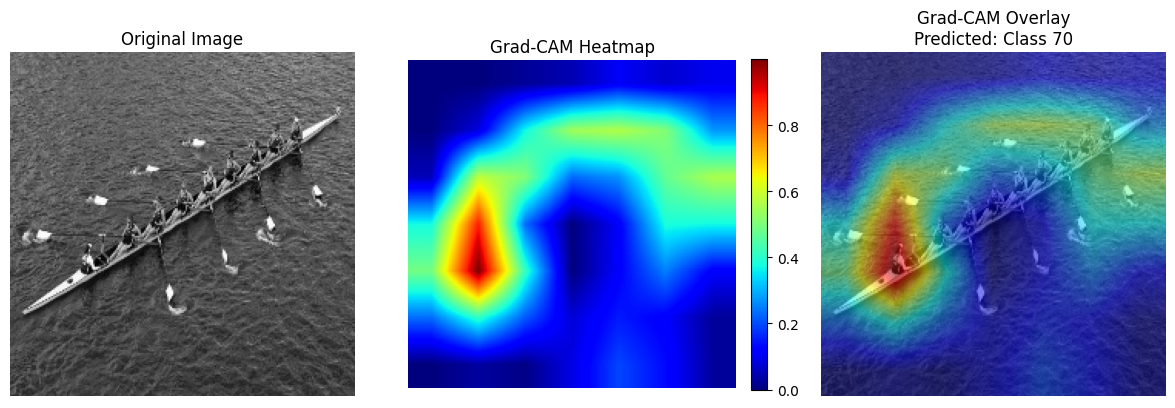


Showing Grad-CAM for: Dataset/valid/javelin/1.jpg


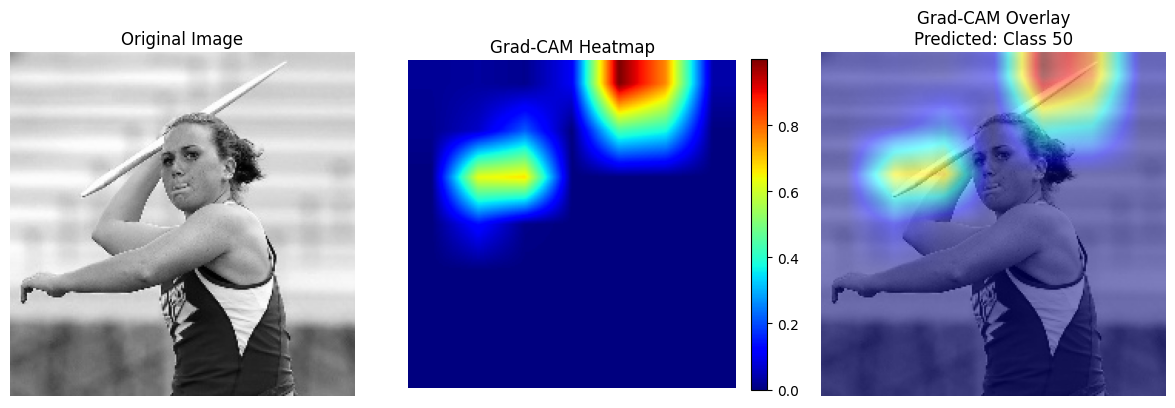

In [24]:
show_gradcam_for_random_samples('Dataset/valid', model, num_samples=10)